In [172]:
import locale
locale.setlocale(locale.LC_NUMERIC, 'C')
import sys
sys.path.append('/Users/nwilming/u')
%pylab
%matplotlib inline
import seaborn as sns
from conf_analysis.behavior import normative as nrm, fstnrm as fast
sns.set_style('ticks')
%load_ext autoreload
%autoreload 2
%aimport -fast

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Ideal observer analysis
----------------------


The task of the observer is to answer the question "Has the $2^{nd}$ grating higher confidence?". The observer answers with no or yes and indicates his/her confidence. The ideal strategy to solve the task is to compute the probability that the $2^{nd}$ grating has higher contrast, and to choose $2^{nd}$ if $P( Yes | Data) > 0.5$. I think that any observer who wants to be consistent across judgements needs to make it confidence judgement dependent on the same probability. Assuming that $P( No | Data)$ = $1-P(Yes | Data)$ an good strategy could look like this: 

$$
response = \left\{
  \begin{array}{ll}
    -2 : & P(Yes | x_i) <& c-t\\
    -1 : & P(Yes | x_i) <& c\\
    +1 : & P(Yes | x_i)\ge& c\\
    +2 : & P(Yes | x_i)\ge& c+t\\
  \end{array}
\right.
$$

In this case $x_i$ are the contrast samples and $i$ indexes time, $P(Yes|x_i)$ is the probability that 'Yes' is the correct answer and $t$ is a confidence threshold and $c$ is the criterion of the observer (which should be .5). This implies that the observer needs to compute $P(Yes | x_i)$, e.g. the probability that the correct answer is yes. For simplicity I assume that the reference has a contrast of 0 for now. 

$$
\begin{array}{rl}
    P(Yes|x_i) = & P(\mu>0 | x_i)\\
     = & \int_0^{\infty} P(\mu | x_i) d\mu
\end{array}
$$
The experiment draws samples from a normal distribution. In our case the observer does neither know $\sigma$ nor $\mu$ of the distribution that generates the samples $x_i$. Calculation of $P(\mu | x_i)$ should take this into account.
$$P(\mu | x_i)= \int_{-\infty}^{\infty} P(\mu | x_i, \sigma)P(\sigma) d\sigma$$

Assuming a Normal-Gamma prior leads to the following solution (ref). First I show the prior:
$$ P(\mu, \lambda) = \mathcal{N}(\mu | \mu_0, (\kappa_0 \lambda)^{-1}) Ga(\lambda | \alpha_0, rate=\beta_0)$$


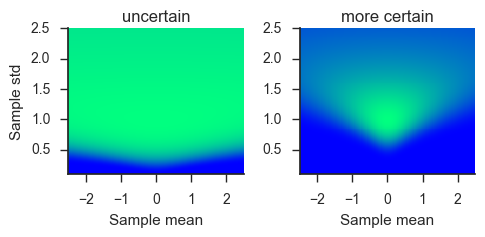

In [347]:
figure(figsize=(5, 2.5))
exprior = array([0, .1, .1, .1])
subplot(1,2,1)
M, P = meshgrid(linspace(-2.5, 2.5, 150), nrm.s2p(linspace(0.1, 2.5, 150)))
pcolor(M, nrm.p2s(P), nrm.NG(M, P, *exprior), cmap=winter())
xlim([-2.5, 2.5])
ylim([0.1, 2.5])
title('uncertain')
xlabel('Sample mean')
ylabel('Sample std')
subplot(1,2,2)
M, P = meshgrid(linspace(-2.5, 2.5, 150), nrm.s2p(linspace(0.1, 2.5, 150)))
pcolor(M, nrm.p2s(P), nrm.NG(M, P, 0, 1, 1, 1), cmap=winter())
xlim([-2.5, 2.5])
ylim([0.1, 2.5])
title('more certain')
xlabel('Sample mean')
sns.despine()
tight_layout()

With this kind of conjugate prior the posterior also becomes a Normal-Gamma distribution. The parameters of the posterior distribution can be computed analytically ($\mu_n$, $\kappa_n$, $\alpha_n$ and $\beta_n$ below). But for our purpose it is usefull to marginalize out the dependence on $\sigma$ directly, i.e. to compute 
$$P(\mu | x_i)= \int_{-\infty}^{\infty} P(\mu | x_i, \sigma)P(\sigma) d\sigma$$

Luckily enough $P(\mu | x_i)$ then becomes a student-T distribution:
$$ P(\mu | x_i) = \mathcal{t}_{v=2\alpha_n} (\mu | \mu_n, \frac{\beta_n}{\alpha_n \kappa_n})$$ 
The parameters are:
$$
\begin{array}{rl}
    \bar{x} = & \frac{1}{n} \sum_{i=1}^n x_i\\
    \mu_n = & \frac{\kappa_0\mu_0 + n\bar{x}}{2(\kappa_0 + n)}\\
    \kappa_n = & \kappa_0 + n\\
    \alpha_n = & \alpha_0 + n/2\\
    \beta_n = &\beta_0 + \frac{1}{2}\sum_{i=1}^{n} (x_i-\bar{x})^2 + \frac{\kappa_0 n (\bar{x} - \mu_0)^2)}{2(\kappa_0 + n)}
\end{array}
$$

The next figure shows one example. We assume the uncertain prior above and calculate the posterior for a sample with mean .5 and sigma 1.

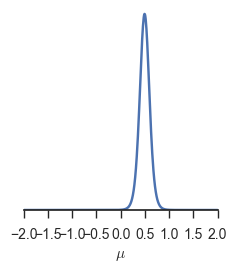

In [5]:
figure(figsize=(2.5,2.5))
m = linspace(-2, 2, 500)
plot(m, nrm.t(*nrm.Mu_posterior(.5, 1, 10, exprior)).pdf(m))
xlabel(r'$\mu$')
yticks([])
sns.despine(left=True)

With this we can compute the probability that $\mu\gt 0$. This is simply given by the CDF of the posterior:
$$P(\mu\gt 0| x_i) = 1 - \mathcal{T}_{v=2\alpha_n}(0 | \mu_n, \frac{\beta_n}{\alpha_n \kappa_n})$$
The posterior only depends on the prior and the sample mean and sample sigma (because the parameters of the posterior depend only on this). We can therefore compute the 'choice' surface, i.e. $P(\mu\gt 0| x_i)$ as a function of the sample mean and sigma:

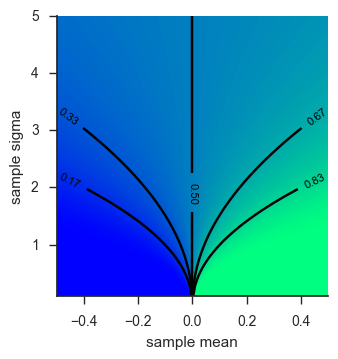

In [385]:
figure(figsize=(3.5, 3.5))
M, S = meshgrid(linspace(-.5, .5, 150), linspace(0.1, 5., 150))
contourf(M, S, nrm.plarger(M, S, 10, exprior), 100, vmin=0, vmax=1)
CS = contour(M, S, nrm.plarger(M, S, 10, exprior), linspace(0, 1, 7)[1:-1], colors=['k'])
clabel(CS, linspace(0, 1, 7)[1:-1], fontsize=8, fmt='%1.2f')
xlim([-.5, .5])
xlabel('sample mean')
ylabel('sample sigma')
sns.despine()


We can now compute the posterior ratio that participants should answer 'Yes' or 'No':
$$ LPR(x_i) = \frac{P(\mu\gt 0| x_i)} {P(\mu\lt 0| x_i)} = \frac{P(\mu\gt 0| x_i)} {1-P(\mu\lt 0| x_i)} = log P(\mu\gt 0| x_i) - log (1-P(\mu\gt 0| x_i))$$

The next figure plots this posterior ratio for several priors. Priors are in the top row, posteriors in the bottom row.

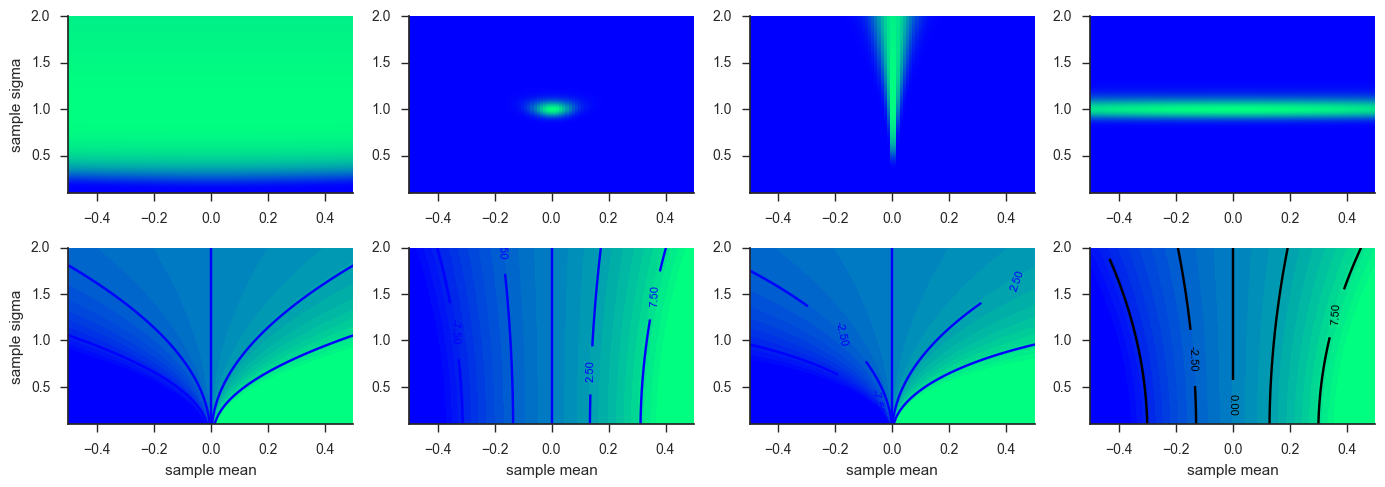

In [417]:
figure(figsize=(14, 5))
gs = matplotlib.gridspec.GridSpec(2, 4)
priors = [
    exprior,
    array([0, 20, 70, 70.]),
    array([0, 75, .1, .01]),
    array([0, 1, 40, 40.])]

for i, prior in enumerate(priors):
    subplot(gs[0, i])
    M, P = meshgrid(linspace(-2.5, 2.5, 450), nrm.s2p(linspace(0.1, 2.5, 450)))
    M, S = meshgrid(linspace(-2.5, 2.5, 450), linspace(0.1, 2.5, 450))
    pcolor(M, nrm.p2s(P), nrm.NG(M, P, *prior), cmap=winter())
    xlim([-.5, .5])
    ylim([0.1, 2])
    if i==0:
        ylabel('sample sigma')
    subplot(gs[1, i])
    LPR =  nrm.logLPR(M, S, prior)
    contourf(M, S, LPR, 100, cmap=winter(), vmin=-10, vmax=10) 
    CS = contour(M, S, LPR, [-7.5, -2.5, 0., 2.5, 7.5], colors=['k'])
    clabel(CS, [-7.5, -2.5, 0., 2.5, 7.5], fontsize=8, fmt='%01.2f')
    xlim([-.5, .5])
    xlabel('sample mean')
    if i==0:
        ylabel('sample sigma')
    xlim([-.5, .5])
    ylim([0.1, 2])

tight_layout()
sns.despine()

A few observations: 
 - Sanity check 1: 0 is at the reference contrast.
 - A very vague priro leads to a strong dependence of confidence on the sample sigma. The higher the sample sigma the higher the mean contrast needs to be to keep confidence constant.
 - A very precise prior removes this dependency. Is this mostly because the prior is narrow in sigma or mean?
 - A prior that is precise in the mean ($3^{rd}$ column) still has the dependency, so the width of the prior in sigma appears to be important.
 - The $4^{th}$ column shows that prior that is precise in sigma but not in the mean does not show the dependency.
 
 The next section investigates this a bit more.

What is the correct prior?
=======================


In the experiment participants have access to many samples. Can we fit a 'prior' believe by estimating the NG distribution that best estimates these values? 

My first idea was to estimate the generative mean/sigma of a lot of samples and then just use the posterior distribution of those samples as a new prior. In this case the precision of the estimated sigma largely determines the shape of the posterior. The larger the precision, the more parallel the posterior becomes.

Step by step: The next plot shows samples as they could have appeared in the experiment (the density plot on the left in a panel, a 2x2 block is one panel). I then fit the posterior distribution $P(\mu, \sigma | samples)$ and plot it's marginals in the bottom. The upper right of a panel shows the posterior again.

The figure also contains two panels. The left 2x2 block uses a small number of samples (36 or so) and the right block uses factor 100 more samples. But the mean and sigma stays the same between the samples.  

0.000161341604929
0.000164003297794


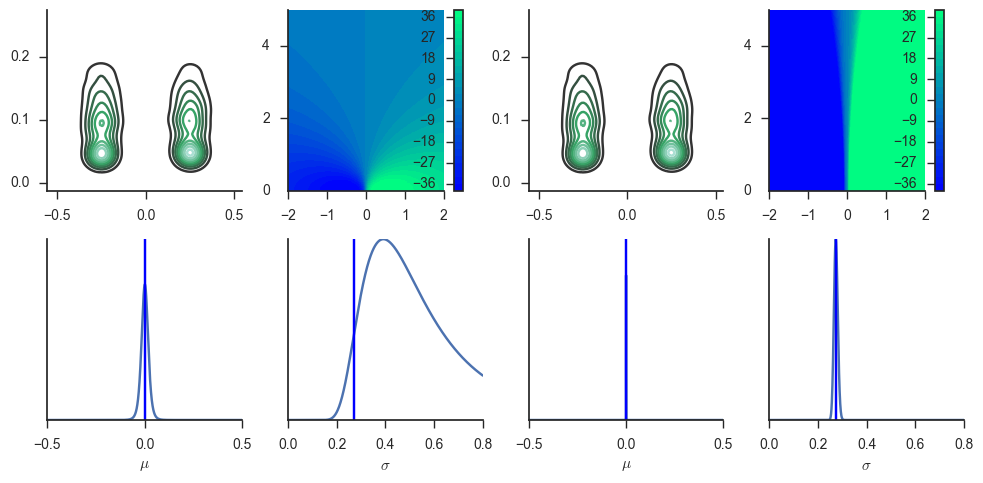

In [8]:
def overview_plot(samples, prior, Nsample=None, gs=None, offset=0):    
    if gs is None:
        gs = matplotlib.gridspec.GridSpec(2,2)
    if Nsample is None:
        Nsample = len(samples)
    mun, kn, an, bn = nrm.NGposterior(samples.mean(), samples.std(), Nsample, prior)
    prior = (mun, kn, an, bn)
    posterior_mean = nrm.t(2*an, mun, bn/(an*kn))
    posterior_sigma = nrm.gamma(an, scale=1./bn)
    subplot(gs[0, offset+0])
    sns.kdeplot(samples.mean(1), samples.std(1))
    pyplot.locator_params(nbins=4)
    
    subplot(gs[0, offset+1])
    M, S = meshgrid(linspace(-2, 2, 500), linspace(0.001, 5, 150))
    LPR =  nrm.logLPR(M, S, prior)
    contourf(M, S, LPR, 25)
    colorbar()
    #axvline(mun, color='k')
    #axvline(-mun, color='k')
    pyplot.locator_params(nbins=4)

    subplot(gs[1, offset+0])
    x = linspace(-.5, .5, 10000)
    plot(x, posterior_mean.pdf(x))
    xlabel(r'$\mu$')
    pyplot.locator_params(nbins=4)
    yticks([])
    axvline(samples.mean())
    subplot(gs[1, offset+1])
    x = nrm.s2p(linspace(0.001,  0.8, 1000))
    yticks([])
    plot(nrm.p2s(x), posterior_sigma.pdf(x))
    xlabel(r'$\sigma$')
    pyplot.locator_params(nbins=4)
    sns.despine()
    axvline(samples.std())
    tight_layout()
    print mun

figure(figsize=(10, 5))
gs = matplotlib.gridspec.GridSpec(2, 4)
samples = nrm.get_samples(N=600, symmetric=True)
overview_plot(samples, exprior, Nsample=6, gs=gs)
overview_plot(samples, exprior, gs=gs, Nsample=600, offset=2)

Clearly fewer samples lead to less certainty in the prior, i.e. the marginals on the left are wider than those on the right. The effect appears to be much stronger for sigma than for mu. In turn, more precision in the prior leads to a posterior surface that is almost parallel such that confidence does not depend on the sample sigma.

Why does this happen? The posterior is defined by $log(P(\mu>0| x_i)) - log(P(\mu<0| x_i))$ and since the two probabilities are 1-each other, it is enough to look at one of the two in these two situations. The posterior $\mu$ distribution is 
$$P(\mu|x_i) = \mathcal{t}_{2\alpha_n} (\mu | \mu_n, \beta_n / (\alpha_n \kappa_n))$$
All of these parameters depend on the prior:

$$
\begin{array}{rl}
    \mu_n = & \frac{\kappa_0\mu_0 + n\bar{x}}{2(\kappa_0 + n)}\\
    \kappa_n = & \kappa_0 + n\\
    \alpha_n = & \alpha_0 + n/2\\
    \beta_n = &\beta_0 + \frac{1}{2}\sum_{i=1}^{n} (x_i-\bar{x})^2 + \frac{\kappa_0 n (\bar{x} - \mu_0)^2)}{2(\kappa_0 + n)}
\end{array}
$$

So we can ask how the posterior distribution changes when the prior changes. Let's do a little experiment. We keep sigma, mean and prior the same and see what happends when the sample size changes:

(0.00016134160492850894, 6.1, 3.1, 0.322016986901452)
(0.00016400329779435167, 600.1, 300.1, 22.301698559165448)


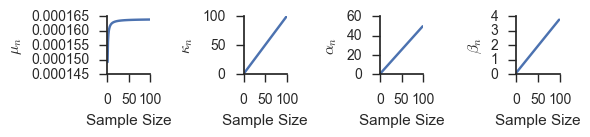

In [9]:
uncertain = nrm.NGposterior(samples.mean(), samples.std(), 6, exprior)
certain = nrm.NGposterior(samples.mean(), samples.std(), 600, exprior)
print uncertain
print certain
ss = arange(1, 100)
figure(figsize=(6, 1.5))
values = [nrm.NGposterior(samples.mean(), samples.std(), s, exprior) for s in ss]
labels = [r'$\mu_n$', r'$\kappa_n$', r'$\alpha_n$', r'$\beta_n$']
for i,p in enumerate(array(values).T):
    subplot(1,4,i+1)
    _=plot(ss, p)
    pyplot.locator_params(nbins=4)
    xlabel('Sample Size')
    ylabel(labels[i])
sns.despine()
tight_layout()

So in a way, if we change the sample size we simply scale $\kappa_0$, $\alpha_0$ and $\beta_0$ with the sample size. The parameters for the posterior are:
$$
\begin{array}{rl}
    df = & 2\alpha_n = 2 \alpha_0 + n/2\\
    loc = & \mu_n = \frac{\kappa_0\mu_0 + n\bar{x}}{\kappa_0 + n}\\
    scale = & \frac{\beta_n}{\alpha_n \kappa_n} 
\end{array}
$$
The df parameter will increase with certainty, which implies that the $\mathcal{t}$ distribution becomes more and more normal. The location parameter will be closer and closer to the prior $\mu$ with an increase in sample size in the prior, the size of this bias depends on $\kappa_0$. The scale parameter depends in a non straightforward way on the uncertainty because $\beta_n$ depends on $\beta_0$ and $\kappa_0$. But it definetly decreases with certainty. This creates a situation where the posterior becomes more normal, closer to the prior mean with certainty in the prior and less variable. 

We can use these properties to explain the features of the log PR space plotted above. For high uncertainty in the prior, the mean of the posterior is close to the sample mean and the uncertainty is comparably large. For high certainty the situation should be reversed. If we were to plot the mean of the posterior for high and low uncertainty in the prior, we would confirm that the mean moves strongly with the sample mean in the high uncertainty case but almost not at all in the high certainty case. Conversely, the sigma of the posterior is very low and almost independent of the sample sigma in the high certainty case but not in the high uncertainty case. 

I really should make a full figure out of this.

A full decision model
=====================

In a first step I will implement an ideal observer that gets trials and decides what to do. It translates the log posterior ration into decisions according to the following rules:

$$
response = \left\{
  \begin{array}{ll}
    -2 : & P(Yes | x_i) <& c-t\\
    -1 : & P(Yes | x_i) <& c\\
    +1 : & P(Yes | x_i)\ge& c\\
    +2 : & P(Yes | x_i)\ge& c+t\\
  \end{array}
\right.
$$

A different sheme might translate the log posterior ratio into the probabilities of a multinomial distribution and then samples this distribution. But at the moment it is not clear to me how to do this in a nice and elegant way. A topic for future thoughts.

Anyway, implementing the scheme above leads to the following response surface, different colors indicate different answers:

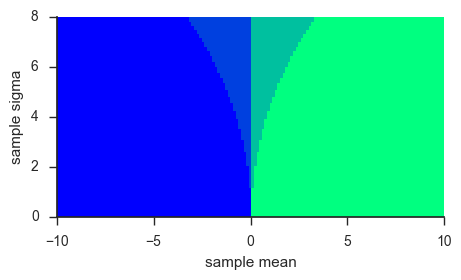

In [418]:
figure(figsize=(5, 2.5))
M, S = meshgrid(linspace(-10, 10, 150), linspace(0.001, 8, 150))
p = array(uncertain)
p[0] = .0
obs = nrm.IdealObserver(bias=0, conf_threshold=log(3.5), prior=p)
D = obs(M.ravel(), S.ravel()).reshape(M.shape)
pcolor(M, S, D)
xlabel('sample mean')
ylabel('sample sigma')
pyplot.locator_params(nbins=4)
sns.despine()

We can also ask the model to classify individual samples for us. But since the model is noise free at the moment there are no surprises here:

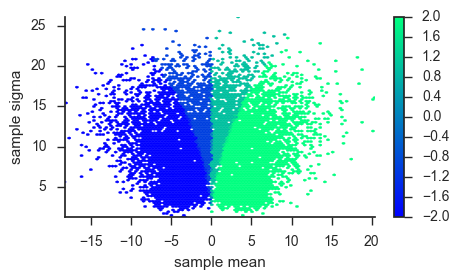

In [420]:
figure(figsize=(5, 2.5))
obs = nrm.IdealObserver(bias=0, conf_threshold=log(1.5), prior=array(uncertain))
samples = nrm.get_samples(N=2000, thresh=4,  symmetric=True, vars=[5, 10,  15])
m, s = samples.mean(1), samples.std(1)
d = obs(m, s)
hexbin(m,s,d)
xlabel('sample mean')
ylabel('sample sigma')
sns.despine()
colorbar()

I now want to fit this model to behavioral data. In total this model has six parameters (the parameter vector shall be called $\theta$). A confidence threshold, bias and the four paramters for the prior. How can we determine these parameters? Maybe we can treat the answer as coming from a multinomial distribution where the probabilities ($\pi_i$) for the four answers are given by the model. This would allow us to define a likelihood function for computing $P(D| \theta)$. I think the key question would be to decide if there is noise in the system. A good diagnostic for noise in the system would be if the same input leads to specific outputs with a certain probability. But at the moment I will skip this. 

The log likelihood function for optimization now becomes:
$$ LL = multinom(r, p) $$ 
$r$ is a 4 dimensional vector that dummy codes the choice, $p$ encodes the probabilities for each choice. $p$ is determined by the log posterior ratio:

\begin{array}{ll}
p_1 = 1-\delta \ \textrm{iff}\ & P(Yes | x_i) <& c-t, \textrm{else}\ \frac{\delta}{3}\\
p_2 = 1-\delta \ \textrm{iff}\ & P(Yes | x_i) <& c, \textrm{else}\ \frac{\delta}{3}\\
p_3 = 1-\delta \ \textrm{iff}\ & P(Yes | x_i)\ge& c, \textrm{else}\ \frac{\delta}{3}\\
p_4 = 1-\delta \ \textrm{iff}\ & P(Yes | x_i)\ge& c+t, \textrm{else}\ \frac{\delta}{3}\\
\end{array}

$\delta$ is a fudge vector to account for lapses in responses and other errors.

@Tobi: From here on documentation is still in the making. I'll complete this in the next days.

In [422]:
_='''
fit_params = {}
fit_params['prior'] = array(uncertain)
fit_params['prior'][0] = 0
fit_params['bias'] = 0
fit_params['conf_threshold'] = log(2.5)

obs = nrm.IdealObserver(**fit_params)

samples = nrm.get_samples(N=200, thresh=4,  symmetric=True, vars=[5, 10,  15])
answers = obs(samples.mean(1), samples.std(1))
bias, cutoff, prior, x = nrm.fit(answers, samples.mean(1), samples.std(1), Ns=3)
'''

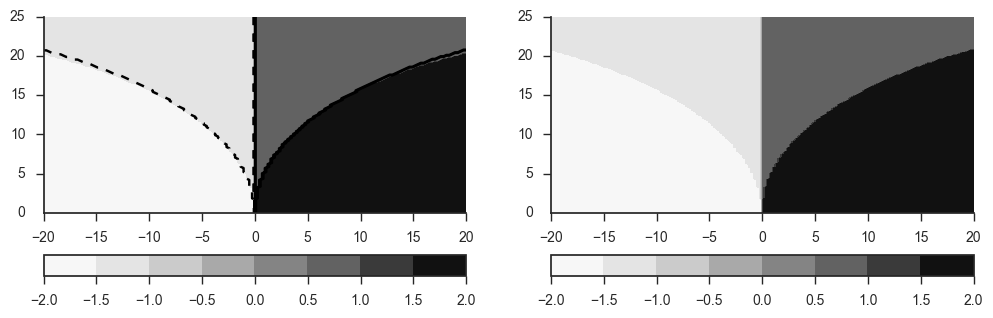

In [53]:
def fitplot(obs, fitted_obs, samples):

    M, S = meshgrid(linspace(-20, 20, 150), linspace(0.001, 25, 150))
    fitted_answers = fitted_obs(M.ravel(), S.ravel()).reshape(M.shape)
    true_answers = obs(M.ravel(), S.ravel()).reshape(M.shape)
    figure(figsize=(12, 3.5))
    subplot(1,2,1)
    contourf(M, S, true_answers, zorder=1)
    #hexbin(samples.mean(1), samples.std(1), answers, gridsize=20, cmap=plt.get_cmap('RdBu'))
    sns.despine()
    colorbar(orientation='horizontal')
    contour(M, S, fitted_answers, zorder=1, colors='k')

    subplot(1,2,2)
    contourf(M, S, fitted_answers, zorder=1)
    colorbar(orientation='horizontal')
    sns.despine()
    
    
fitted_obs = nrm.IdealObserver(bias=bias, conf_threshold=log(cutoff), prior=prior)
fitplot(obs, fitted_obs, samples)

Fit to data!
============

In [331]:
%pylab
from conf_analysis.behavior import empirical
data = empirical.data_cleanup(empirical.load_data())

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [199]:
def do(m):
    answers = m.response*m.confidence
    rranges = (
           (-4, 4),  # Bias
           (1., 10.), # Conf threshold
           (-15, 15),# mean prior
           (0, 5),   # kappa
           (0, 10),  # alpha
           (0, 10))

    con = vstack(m.contrast_probe)
    con = (con-mean(con))/abs(con-mean(con)).std()
    bias, cutoff, prior, x = nrm.fit(answers, con.mean(1), con.std(1), Ns=10)
    fitted_obs = nrm.IdealObserver(bias=bias, conf_threshold=log(cutoff), prior=prior)
    return fitted_obs, bias, cutoff, prior, x, con.mean(1), con.std(1)


def fitplot(fitted_obs, sample_mean, sample_sigma, m):
    matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
    M, S = meshgrid(linspace(-3, 3, 450), linspace(0.0001, 3, 450))
    fitted_answers = fitted_obs(M.ravel(), S.ravel()).reshape(M.shape)
    CS= contourf(M, S, fitted_answers, zorder=-1)
    CS= contour(M, S, fitted_answers, colors=['k'], zorder=2)
    hexbin(sample_mean, sample_sigma, m.confidence.values-1, gridsize=15, zorder=1, 
           cmap=plt.get_cmap('winter'), mincnt=5)
    #cbar = colorbar(shrink=0.95, ticks=[0.2, 0.6])
    #cbar.set_label('P(High confidence)', rotation=270)
    xlabel('Mean sample contrast')
    ylabel('Sample std')
    ylim([0, 3])
    tight_layout()
    sns.despine()



In [234]:
b = nrm.NrmModel()
b.score([data.mc, data.stdc], data.response*data.confidence)

56131.689552321484

In [332]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from scipy import stats
s5 = data.query('snum==6')
def randomsearch(m):
    answers = m.response*m.confidence
    # specify parameters and distributions to sample from
    param_dist = {
          "bias": stats.norm(0, 3),
          "conf_threshold": stats.truncnorm(-1.5/2.5, inf, loc=1.5, scale=1.5),
          "mu0": stats.norm(0, 3),
          "kappa0": stats.truncnorm(-1.5/2.5, inf, loc=1.5, scale=1.5),
          "alpha0": stats.truncnorm(-1.5/5.5, inf, loc=1.5, scale=5.5),
          "beta0": stats.truncnorm(-1.5/5.5, inf, loc=1.5, scale=5.5)
        }
    
    con = vstack(m.contrast_probe)
    con = (con-mean(con))/abs(con-mean(con)).std()
    model = nrm.NrmModel()
    search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=15000, cv=2, verbose=0, n_jobs=3)
    return search.fit(vstack([con.mean(1), con.std(1)]).T, answers).best_estimator_

s = randomsearch(s5)

Bias: -3.6, conf_threshold: 2.4, prior:-3.9511  1.7495  0.7341  5.5076  
Optimization terminated successfully.
         Current function value: 4516.721995
         Iterations: 38
         Function evaluations: 131
-3.70708396901
Bias: -3.7, conf_threshold: 2.4, prior:-4.0159  1.6653  0.7436  5.5992  


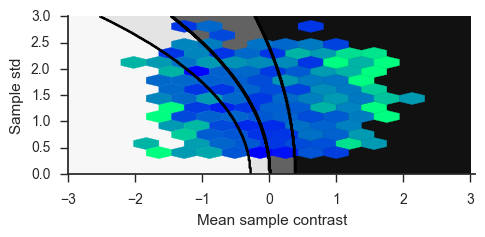

In [337]:
figure(figsize=(5, 2.5))
print s
s5 = data.query('snum==6')
con = vstack(s5.contrast_probe)
con = (con-mean(con))/abs(con-mean(con)).std()
fitme = nrm.NrmModel().set_params(**s.get_params())
answers = s5.response*s5.confidence
fitted = fitme.fit(vstack([con.mean(1), con.std(1)]).T, answers, opt_fit=True)
fitplot(fitted, con.mean(1), con.std(1), s5)
print fitted

In [339]:
log(3.7)

1.3083328196501789

kurios = data.groupby('snum').apply(do)

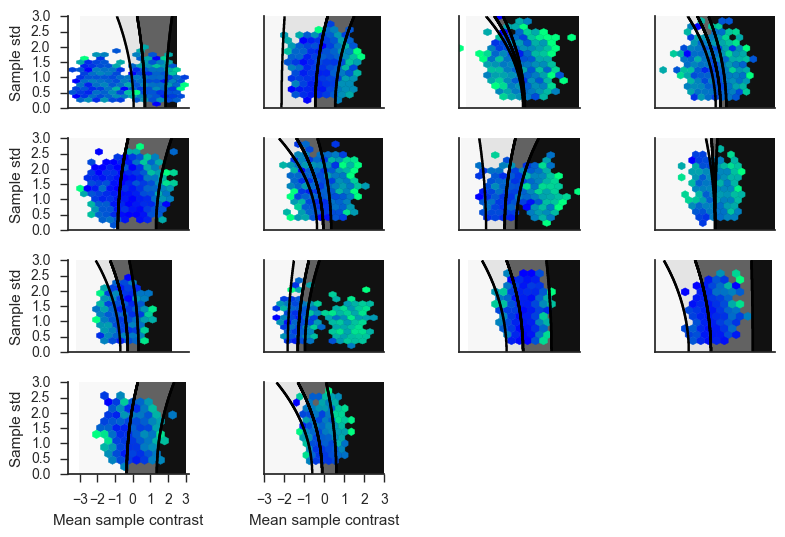

In [200]:
for snum, d in kurios.groupby(level='snum'):
    subplot(4,4,snum)
    fitted_obs, bias, cutoff, prior, x, sample_mean, sample_std = d.loc[snum]
    fitplot(fitted_obs, sample_mean, sample_std, data.query('snum==%i'%snum))
    if mod(snum-1, 4):
        ylabel('')
        yticks([])
    if snum<13:
        xticks([])
        xlabel('')
sns.despine()

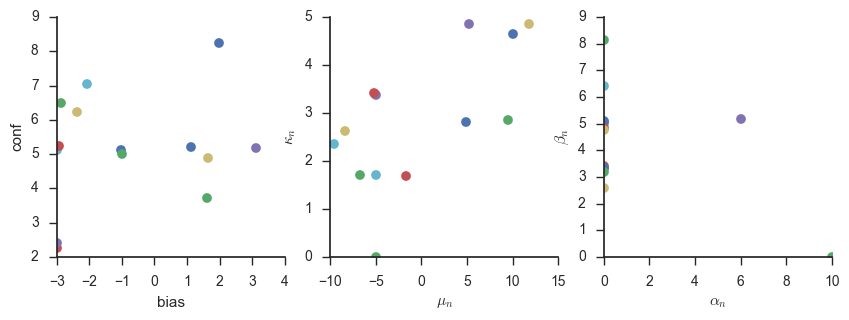

In [203]:
figure(figsize=(10, 3))
for snum, k in kurios.iteritems():
    fitted_obs, bias, cutoff, prior, x, sample_mean, sample_std = k
    subplot(1,3,1)
    plot(bias, cutoff, 'o')
    xlabel(r'bias')
    ylabel(r'conf')
    subplot(1,3,2)
    plot(prior[0], prior[1], 'o')
    xlabel(r'$\mu_n$')
    ylabel(r'$\kappa_n$')
    subplot(1,3,3)
    plot(prior[2], prior[3], 'o')
    xlabel(r'$\alpha_n$')
    ylabel(r'$\beta_n$')
sns.despine()

(array([  432.,  1278.,   694.,   926.,   668.,   486.,   312.,   116.,
           74.,    14.]),
 array([ 0.13427799,  0.33231196,  0.53034593,  0.7283799 ,  0.92641388,
         1.12444785,  1.32248182,  1.5205158 ,  1.71854977,  1.91658374,
         2.11461771]),
 <a list of 10 Patch objects>)

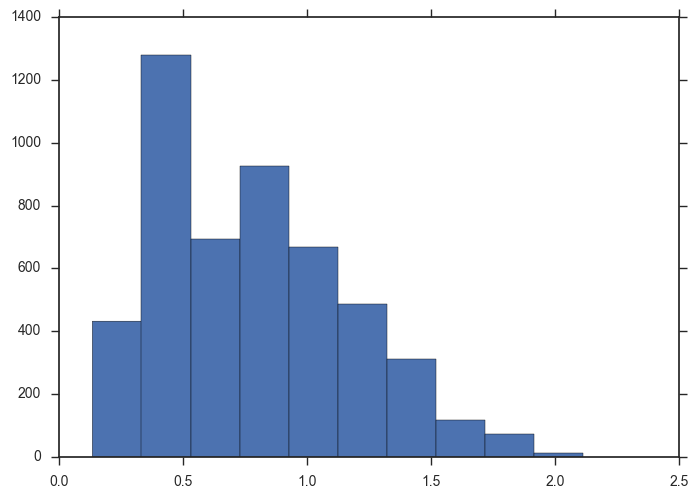

In [191]:
d1 = data.query('snum==1')
con = vstack(d1.contrast_probe)
con = (con-mean(con))/abs(con-mean(con)).std()
hist(con.std(1))

Bias: -3.0, conf_threshold: 1.8, prior:-6.2458  2.1959  0.0009  5.5678  


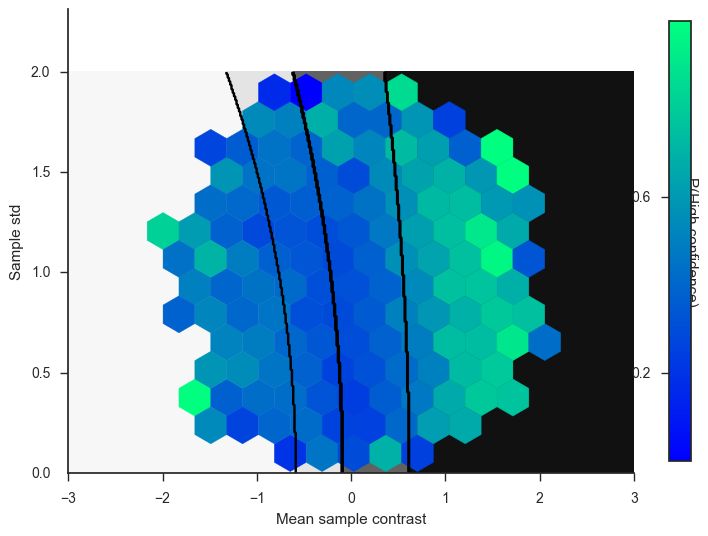

In [124]:
from conf_analysis.behavior import normative as nrm
data = data[(~(isnan(data.response) | isnan(data.confidence)))]
for snum, sdata in data.groupby('snum'):
    subplot(4,4, snum)
    fitted_obs, bias, cutoff, prior, x, sample_mean, sample_sigma = do(data)
    fitplot(fitted_obs, sample_mean, sample_sigma, data)  


In [113]:
data['fitted_response'] = sign(fitted_obs(sample_mean, sample_sigma))
data['fitted_confidence'] = abs(fitted_obs(sample_mean, sample_sigma))

[ 1.] [ 0.1141855] 0.05
[ 1.] [ 0.21573948] 0.1
[ 1.] [ 0.30314258] 0.15


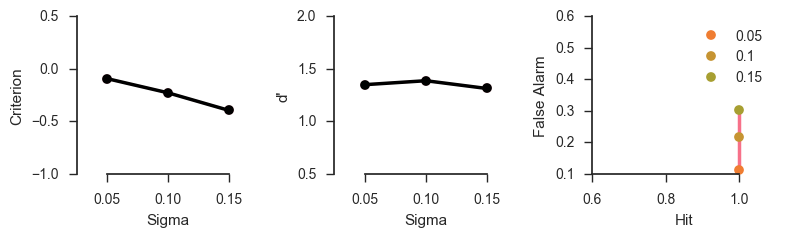

In [114]:
figure(figsize=(8,2.5))
with sns.color_palette("husl", 14):
    subplot(1,3,1)
    t1 =(data.groupby(['noise_sigma'])
             .apply(lambda x: empirical.crit(x, field='fitted_response')).reset_index()
             .pivot_table(index='noise_sigma'))
    plot(t1.index.values, t1.values, 'o-', alpha=0.5)
    plot(t1.index.values, t1.values.mean(1), 'ko-', lw=2.5)
    pyplot.locator_params(nbins=4)
    ylabel('Criterion')
    xlabel('Sigma')
    xlim([0.025, 0.175])
    ylim([-1, 0.5])
    
    subplot(1,3,2)
    t1 =(data.groupby(['noise_sigma'])
             .apply(lambda x: empirical.dp(x, field='fitted_response')).reset_index()
             .pivot_table(index='noise_sigma'))
    plot(t1.index.values, t1.values, 'o-', alpha=0.5)
    plot(t1.index.values, t1.values.mean(1), 'ko-', lw=2.5)
    pyplot.locator_params(nbins=4)
    ylabel(r"d'")
    xlabel('Sigma')
    xlim([0.025, 0.175])
    ylim([0.5, 2])
    subplot(1,3,3)
    hit =(data.groupby(['noise_sigma'])
             .apply(lambda x: empirical.tbl(x, field='fitted_response')[0]).reset_index()
             .pivot_table(index='noise_sigma'))
    fa =(data.groupby(['noise_sigma'])
             .apply(lambda x: empirical.tbl(x, field='fitted_response')[1]).reset_index()
             .pivot_table(index='noise_sigma'))
    plot(hit.mean(1), fa.mean(1), '-', lw=2.5)
    for h, f, n in zip(hit.values, fa.values, hit.index):
        print h, f, n
        plot(h, f, 'o', label=n)
    legend()
    xlabel('Hit')
    ylim([0.1, 0.6])
    xlim([0.6, 1.1])
    ylabel('False Alarm')
    pyplot.locator_params(axis='y', nbins=5)
    pyplot.locator_params(axis='x', nbins=5)
    sns.despine(trim=True)
    tight_layout()


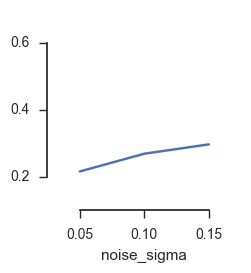

In [123]:
figure(figsize=(2.5, 2.5))
data['fitted_conf_0index'] = data.fitted_confidence-1
m = data.groupby('noise_sigma').fitted_conf_0index.mean()
m.plot()
ylim([0.1, 0.7])
xlim([0.025, 0.175])
pyplot.locator_params(nbins=4)

sns.despine(trim=True)

The predictive distribution
===========================


In [ ]:
samples = nrm.get_samples(200, symmetric=False, vars=[0.05, .1, 0.15]).ravel()
print samples.shape
#m, s = samples.mean(1), samples.std(1)

mun, kn, an, bn = nrm.NGposterior(samples.mean(), samples.std(), len(samples), exprior)
kn1 = kn+1
an1 = an+.5
bn1 = bn + ( (kn*(samples.mean()-mun)**2)/(2*(kn+1)))

loc = mun
df = 2*an
scale = (an*kn)/(bn*(kn+1))
print df, nrm.p2s(scale), samples.std()
tpred = nrm.t(df, loc, nrm.p2s(scale))
x= linspace(-.5, .5, 50)
y = tpred.pdf(x)
plot(x, y/y.max())
yy = histogram(samples, bins=x)[0]
ctrs = x[1:] - diff(x)[0]
plot(ctrs, yy/float(max(yy)), 'r-')
sns.despine()

Analysis idea: Variance misperception should evolve with the prior, a.k.a the number of samples seen.